In [ ]:
#default_exp utils

utils from alphatims/alphapept

In [ ]:
#hide
from peptdeep import utils
__file__ = utils.__file__

In [ ]:
#export
import logging
import os
import sys
import tqdm

BASE_PATH = os.path.dirname(__file__)
LOG_PATH = os.path.join(BASE_PATH, "logs")

# from alphatims
def process_bar(iterator, len_iter):
    with tqdm.tqdm(total=len_iter) as bar:
        i = 0
        for i,iter in enumerate(iterator):
            yield iter
            bar.update()
        bar.update(len_iter-i-1)

def set_logger(
    *,
    log_file_name="",
    stream: bool = True,
    log_level: int = logging.INFO,
    overwrite: bool = False,
) -> str:
    """Set the log stream and file.
    All previously set handlers will be disabled with this command.
    Parameters
    ----------
    log_file_name : str, None
        The file name to where the log is written.
        Folders are automatically created if needed.
        This is relative to the current path. When an empty string is provided,
        a log is written to the AlphaTims "logs" folder with the name
        "log_yymmddhhmmss" (reversed timestamp year to seconds).
        If None, no log file is saved.
        Default is "".
    stream : bool
        If False, no log data is sent to stream.
        If True, all logging can be tracked with stdout stream.
        Default is True.
    log_level : int
        The logging level. Usable values are defined in Python's "logging"
        module.
        Default is logging.INFO.
    overwrite : bool
        If True, overwrite the log_file if one exists.
        If False, append to this log file.
        Default is False.
    Returns
    -------
    : str
        The file name to where the log is written.
    """
    import time
    root = logging.getLogger()
    formatter = logging.Formatter(
        '%(asctime)s> %(message)s', "%Y-%m-%d %H:%M:%S"
    )
    root.setLevel(log_level)
    while root.hasHandlers():
        root.removeHandler(root.handlers[0])
    if stream:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(log_level)
        stream_handler.setFormatter(formatter)
        root.addHandler(stream_handler)
    if log_file_name is not None:
        if log_file_name == "":
            if not os.path.exists(LOG_PATH):
                os.makedirs(LOG_PATH)
            log_file_name = LOG_PATH
        log_file_name = os.path.abspath(log_file_name)
        if os.path.isdir(log_file_name):
            current_time = time.localtime()
            current_time = "".join(
                [
                    f'{current_time.tm_year:04}',
                    f'{current_time.tm_mon:02}',
                    f'{current_time.tm_mday:02}',
                    f'{current_time.tm_hour:02}',
                    f'{current_time.tm_min:02}',
                    f'{current_time.tm_sec:02}',
                ]
            )
            log_file_name = os.path.join(
                log_file_name,
                f"log_{current_time}.txt"
            )
        directory = os.path.dirname(log_file_name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        if overwrite:
            file_handler = logging.FileHandler(log_file_name, mode="w")
        else:
            file_handler = logging.FileHandler(log_file_name, mode="a")
        file_handler.setLevel(log_level)
        file_handler.setFormatter(formatter)
        root.addHandler(file_handler)
    return log_file_name
set_logger(log_file_name=None)

def show_platform_info() -> None:
    """Log all platform information.
    This is done in the following format:
        - [timestamp]> Platform information:
        - [timestamp]> system         - [...]
        - [timestamp]> release        - [...]
        - [timestamp]> version        - [...]
        - [timestamp]> machine        - [...]
        - [timestamp]> processor      - [...]
        - [timestamp]> cpu count      - [...]
        - [timestamp]> cpu frequency  - [...]
        - [timestamp]> ram            - [...]/[...] Gb (available/total)
    """
    import platform
    import psutil
    logging.info("Platform information:")
    logging.info(f"system        - {platform.system()}")
    logging.info(f"release       - {platform.release()}")
    if platform.system() == "Darwin":
        logging.info(f"version       - {platform.mac_ver()[0]}")
    else:
        logging.info(f"version       - {platform.version()}")
    logging.info(f"machine       - {platform.machine()}")
    logging.info(f"processor     - {platform.processor()}")
    logging.info(
        f"cpu count     - {psutil.cpu_count()}"
        # f" ({100 - psutil.cpu_percent()}% unused)"
    )
    logging.info(f"cpu frequency - {psutil.cpu_freq().current:.2f} Mhz")
    logging.info(
        f"ram           - "
        f"{psutil.virtual_memory().available/1024**3:.1f}/"
        f"{psutil.virtual_memory().total/1024**3:.1f} Gb "
        f"(available/total)"
    )
    logging.info("")


def show_python_info() -> None:
    """Log all Python information.
    This is done in the following format:
        - [timestamp]> Python information:
        - [timestamp]> alphatims          - [current_version]
        - [timestamp]> [required package] - [current_version]
        - ...
        - [timestamp]> [required package] - [current_version]
    """
    import importlib.metadata
    import platform
    import peptdeep
    module_versions = {
        "python": platform.python_version(),
        "peptdeep": peptdeep.__version__
    }
    requirements = importlib.metadata.requires("peptdeep")
    for requirement in requirements:
        parts = requirement.split(";")
        if len(parts) > 1:
            if "development" in parts[1]:
                continue
            if "win32" in parts[1]:
                continue
        module_name = parts[0].split("=")[0].split()[0]
        try:
            module_version = importlib.metadata.version(module_name)
        except importlib.metadata.PackageNotFoundError:
            module_version = ""
        module_versions[module_name] = module_version
    max_len = max(len(key) for key in module_versions)
    logging.info("Python information:")
    for key, value in sorted(module_versions.items()):
        logging.info(f"{key:<{max_len}} - {value}")
    logging.info("")

In [ ]:
#hide
show_python_info()
show_platform_info()

2022-02-08 23:47:54> Python information:
2022-02-08 23:47:54> biopython    - 1.78
2022-02-08 23:47:54> click        - 7.1.2
2022-02-08 23:47:54> matplotlib   - 3.3.3
2022-02-08 23:47:54> numba        - 0.54.0
2022-02-08 23:47:54> numpy        - 1.19.4
2022-02-08 23:47:54> pandas       - 1.3.5
2022-02-08 23:47:54> peptdeep     - 1.0.0
2022-02-08 23:47:54> python       - 3.8.3
2022-02-08 23:47:54> regex        - 2020.6.8
2022-02-08 23:47:54> scikit-learn - 0.24.2
2022-02-08 23:47:54> seaborn      - 0.11.1
2022-02-08 23:47:54> statsmodels  - 0.11.1
2022-02-08 23:47:54> streamlit    - 1.5.0
2022-02-08 23:47:54> torch        - 1.7.1
2022-02-08 23:47:54> tqdm         - 4.56.0
2022-02-08 23:47:54> transformers - 4.16.1
2022-02-08 23:47:54> 
2022-02-08 23:47:54> Platform information:
2022-02-08 23:47:54> system        - Darwin
2022-02-08 23:47:54> release       - 20.6.0
2022-02-08 23:47:54> version       - 10.16
2022-02-08 23:47:54> machine       - x86_64
2022-02-08 23:47:54> processor     - i

In [ ]:
#export
import pandas as pd
import itertools

def _flatten(list_of_lists):
    '''
    Flatten a list of lists
    '''
    return list(
        itertools.chain.from_iterable(list_of_lists)
    )

def explode_multiple_columns(df:pd.DataFrame, columns:list):
    try:
        return df.explode(columns)
    except ValueError:
        # pandas <= 1.2.x?
        logging.warn(f'pandas=={pd.__version__} cannot explode multiple columns')
        ret_df = df.explode(columns[0])
        for col in columns[1:]:
            ret_df[col] = _flatten(df[col].values)
        return ret_df


## Plotting functions

In [2]:
#export
import statsmodels.api as sm
import pandas as pd
import seaborn as sns

def evaluate_linear_regression(
    df:pd.DataFrame, x='rt_pred', y='rt_norm', 
    ci=95, n_sample=10000000
):
    if len(df) > n_sample:
        df = df.sample(n_sample, replace=False)
    gls = sm.GLS(df[y], sm.add_constant(df[x]))
    res = gls.fit()
    summary = res.summary(alpha=1-ci/100.0)
    dfs = []
    results_as_html = summary.tables[0].as_html()
    dfs.append(pd.read_html(results_as_html, index_col=None)[0])
    results_as_html = summary.tables[1].as_html()
    dfs.append(pd.read_html(results_as_html, index_col=None)[0])
    summary = pd.concat(dfs, ignore_index=True)
    R_square = float(summary.loc[0,3])
    R = np.sqrt(R_square)
    n,b,w = summary.loc[[5,10,11],1].values.astype(float)
    return pd.DataFrame(
        dict(
            R_square=[R_square],R=[R],
            slope=[w],intercept=[b],test_num=[n]
        )
    )

def evaluate_linear_regression_plot(
    df:pd.DataFrame, x='rt_pred', y='rt_norm', 
    ci=95, n_sample=100000
):
    if len(df) > n_sample:
        df = df.sample(n_sample)
    alpha = 0.05
    if len(df) < 5000:
        alpha = 1
    elif len(df) < 50000:
        alpha = 5000.0/len(df)
    return sns.regplot(
        data=df, x=x, y=y, color='r', ci=ci, 
        scatter_kws={'s':0.05, 'alpha':alpha, 'color':'b'}
    )

<AxesSubplot:xlabel='rt_pred', ylabel='rt_norm'>

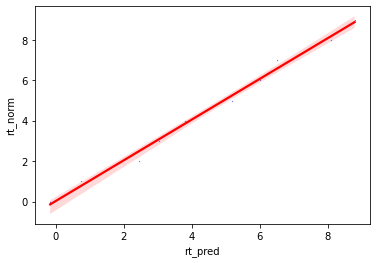

In [3]:
#hide
import pandas as pd
import numpy as np
df = pd.DataFrame({'rt_norm':np.arange(10), 'rt_pred':np.arange(10)+np.random.normal(0,0.3,10)})
evaluate_linear_regression_plot(df)